Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/Documents/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [4]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/Documents/repos/kp-lflm-group/Models_Hamiltonian/";name="kane"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot)

14-element Vector{Num}:
    E_g
 VBO
   c
    F
 k_x
 k_y
 k_z
 g_1
 g_2
    E_p
 g_3
   Δ
   P
  cp

In [5]:
real(Htot)

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                          0.333333Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [6]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);
#p=HVar[13];
p=HVar[13]; kind="nonSymm"
H1l,H1r=KPpack.createH1Corr(H1,p, Emomentum,kind);

## test the bulk calculation

In [7]:
material="InGaAs_0.53"; Temp=200; soc=true; opt="one"
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp,opt);
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [8]:
kmax= 1.4; Nt=20; consth=0.038; const2=sqrt(consth)
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

In [9]:
mm.Eg+mm.VBO

0.22894183944750834

# Plot band diagram

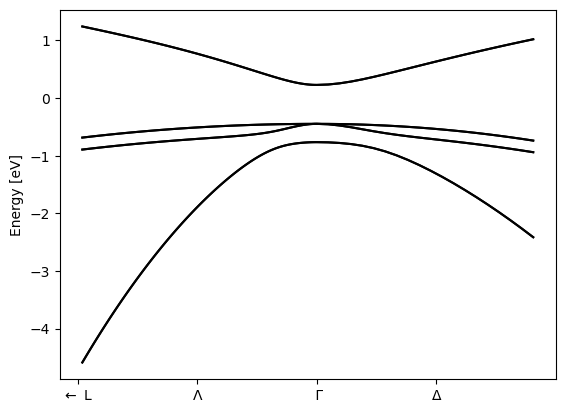

In [10]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

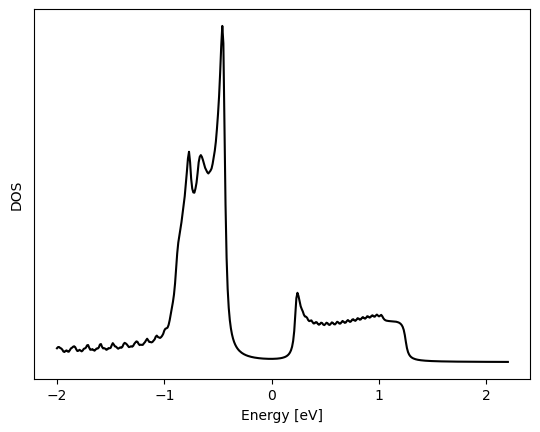

In [11]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [12]:
#structure=["InAlAs_0.48" "2";
#    "InAlAs_0.48" "5";
#    "InGaAs_0.53" "8";
#    "InAlAs_0.48" "2";
#    "InAlAs_0.48" "5";]

structure=[
    "InAlAs_0.52" "10";
    "InGaAs_0.53" "8";
    "InAlAs_0.52" "10";]

#structure=["AlGaAs_0.2" "10";
#    "GaAs" "3";
#    "AlGaAs_0.2" "10";]

Npts,layer,nlayer=KPpack.setStructure(structure,1.3,Temp)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp,opt);
Npts

125

# Plot structure

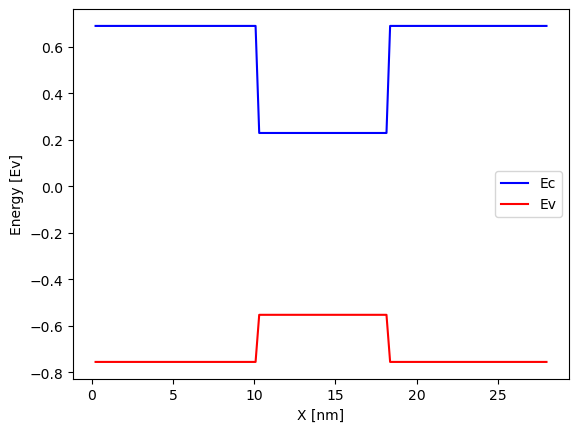

In [13]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

  6.795483 seconds (8.51 M allocations: 590.285 MiB, 3.47% gc time, 77.10% compilation time)


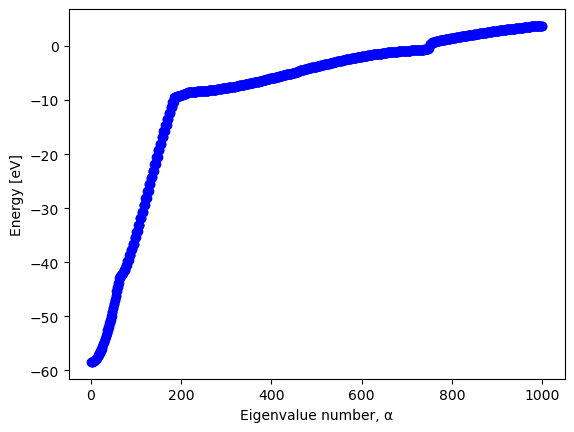

In [14]:
c=0.038; cps=sqrt(c); dx=X[2]-X[1];  cr=0.9; s=0.6; pb=true; siz=size(H0)[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1l,H1r,H2,c,cps,dx,Emomentum,pb,cr,s);
KPpack.PloteigvQW(Npts,Eqw0,siz);


# QW Band Structure Calculation

In [15]:
kmax= 0.9; Nt=100;
nc=6; nv=10

sV,sC,pos=KPpack.eigenValQW(real(Eqw0),siz)
#sV=-0.6; sC=-0.1
pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

 19.241079 seconds (15.18 M allocations: 4.450 GiB, 4.75% gc time, 25.63% compilation time)
 15.410824 seconds (8.07 M allocations: 3.932 GiB, 5.45% gc time)


## Valence Band 

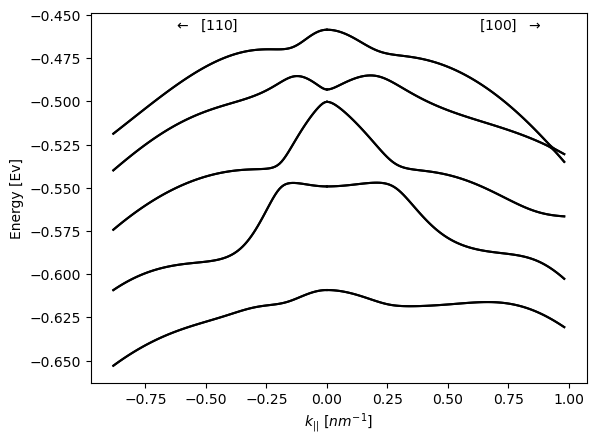

In [16]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

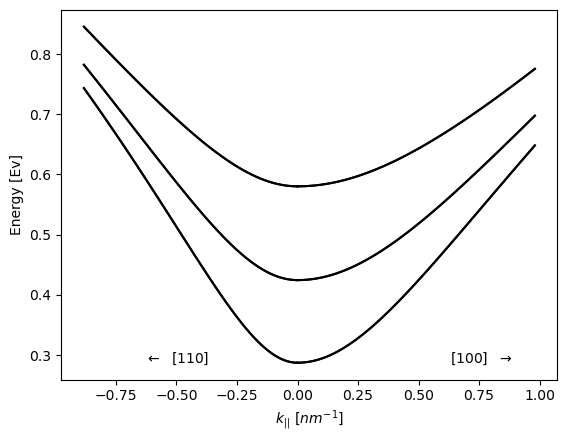

In [17]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

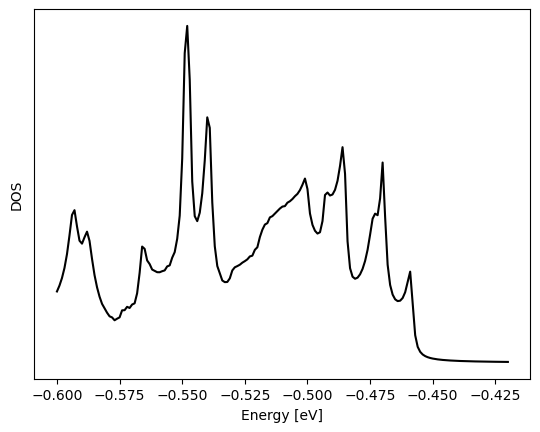

In [18]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.6,-0.42,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

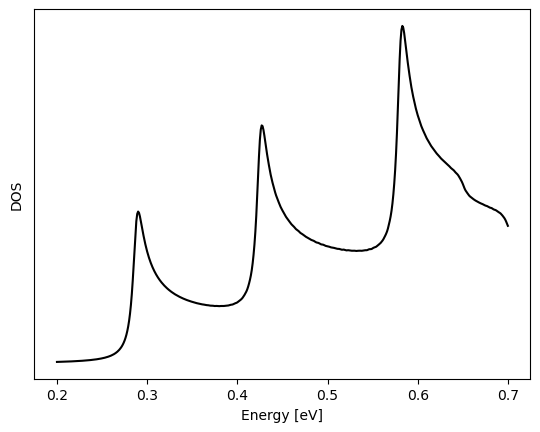

In [19]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.2,0.7,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

## =====================================================|

save a file with band structure

In [20]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

In [21]:
using PyCall, PyPlot

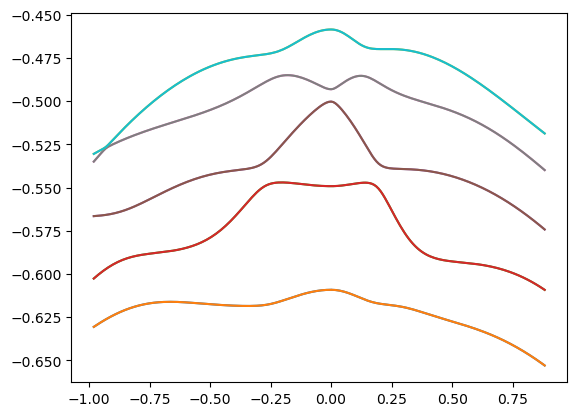

In [22]:
dat1=vcat(transpose(Kqw11), transpose(Evq11))
dat1=transpose(dat1)

dat2=vcat(transpose(-Kqw10), transpose(Evq10))
dat2=transpose(dat2)

datQW=vcat(rotr90(dat2',3),dat1)

plt.plot(datQW[:,1],datQW[:,2:end]);

name="BandStructure_QW_GaAs_1"
KPpack.writefile(datQW,name)

# Envelope functions magnitude

# ================================

## Components of First Conduction band (CB)

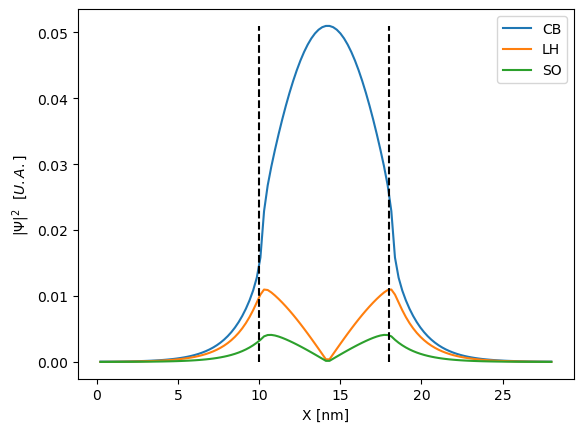

In [34]:
iVec=[1];vecband=[1,4,3]; legendArr=["CB","LH","SO"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)

## Components of Second Conduction band (CB)

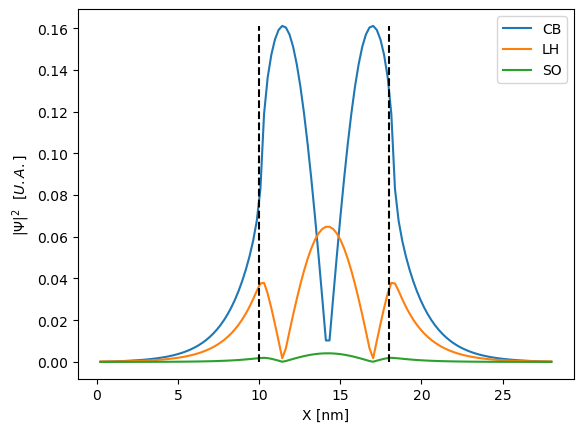

In [35]:
iVec=[3];vecband=[1,4,3]; legendArr=["CB","LH","SO"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)

## Components of First Light Hole band (HL)

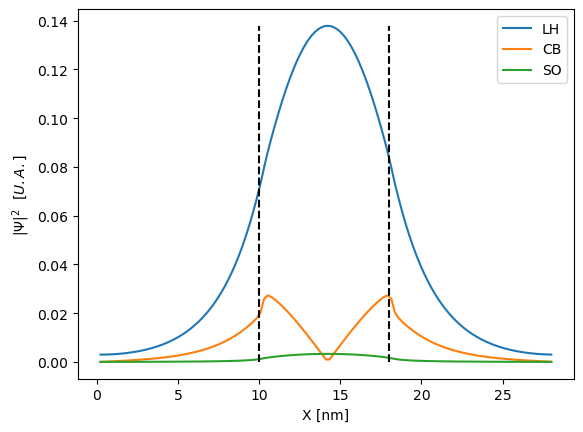

In [36]:
iVec=[-5];vecband=[4,1,3]; legendArr=["LH","CB","SO"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)

# ======================================================

# Surfaces of valence band quantum Well

In [24]:
kinic,kend=-1.0,1.0; kstep=0.1
@time EArr=KPpack.eigenSurface(H0,H1r,H1l,H2,mlayer,dx,c,cps,Npts,Emomentum,pb,cr,s,sV,nv,kinic,kend,kstep);

 59.532167 seconds (35.21 M allocations: 14.537 GiB, 6.05% gc time, 0.39% compilation time)


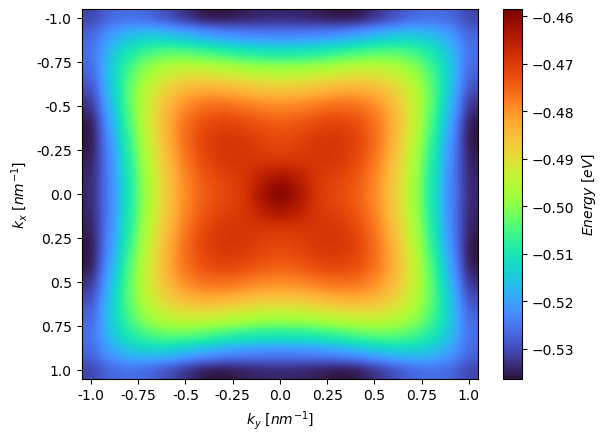

In [25]:
KPpack.plotEigSurface(EArr,1,kinic,kend)

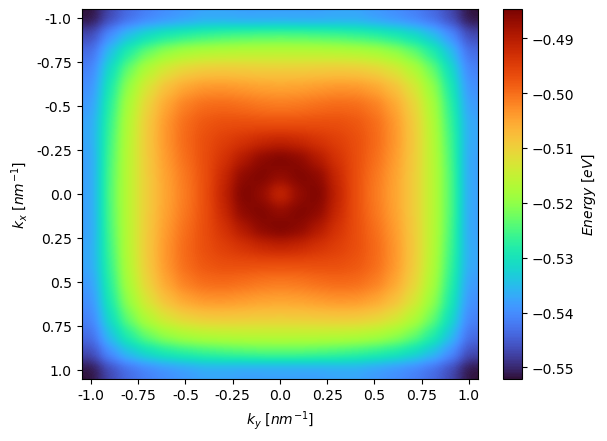

In [26]:
KPpack.plotEigSurface(EArr,3,kinic,kend)

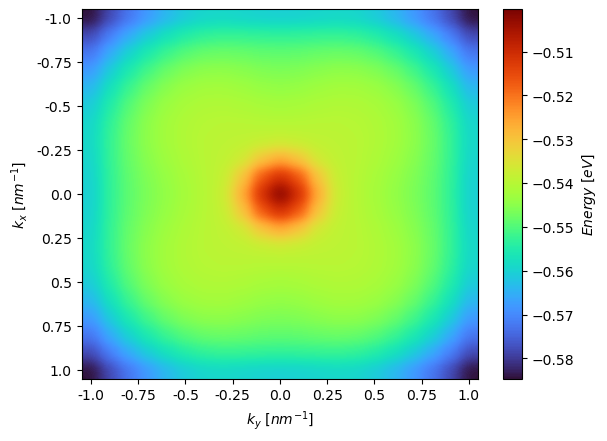

In [27]:
KPpack.plotEigSurface(EArr,5,kinic,kend)

# Surfaces of conduction band quantum Well

In [39]:
kinic,kend=-1.0,1.0; kstep=0.1
@time EArr=KPpack.eigenSurface(H0,H1r,H1l,H2,mlayer,dx,c,cps,Npts,Emomentum,pb,cr,s,sC,nc,kinic,kend,kstep);

 47.511154 seconds (35.00 M allocations: 14.560 GiB, 5.96% gc time)


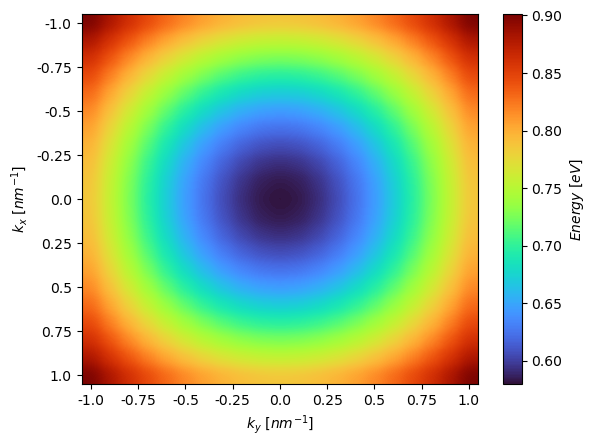

In [40]:
KPpack.plotEigSurface(EArr,1,kinic,kend)

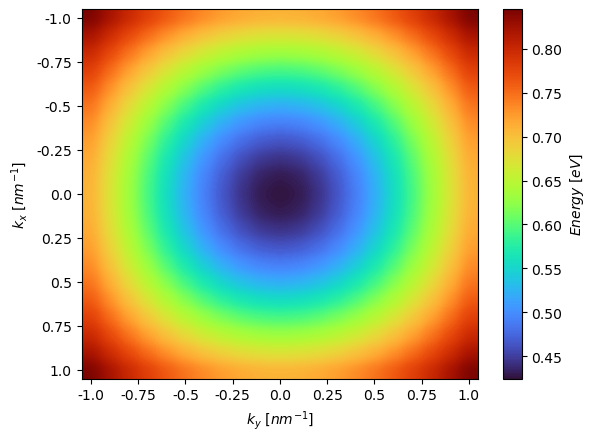

In [41]:
KPpack.plotEigSurface(EArr,3,kinic,kend)

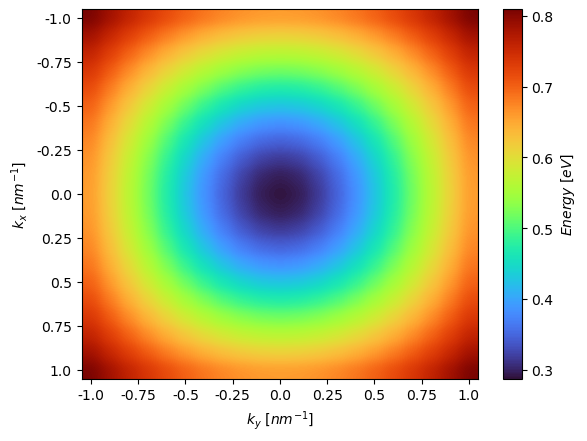

In [42]:
KPpack.plotEigSurface(EArr,5,kinic,kend)

In [28]:
arr=EArr[:,:,5]
arLen=length(arr); iter=size(arr)[1]
#arrimag=zeros(arLen,3)
arrimag=Array{Float64}(undef,1,3); vecij=[0 0 0]
for i in 1:iter
    for j in 1:iter
        vecij=[j i arr[i,j]]
        arrimag=vcat(arrimag,vecij)
    end
end
arrimag=arrimag[2:end,:];

In [29]:
name="hh5"
KPpack.writefile(arrimag,name)